### Load product review csv to pandas data frame and inspect data

In [2]:
import pandas as pd
reviews = pd.read_csv('amazon_baby_products.csv')

In [3]:
reviews.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


#### How does a review with rating 1 look like?

In [4]:
reviews[reviews['rating'] == 1]['review'].iloc[0]

'This book is boring. Nothing to stimulate my granddaughter. It is a waste of money. I would not recommend it'

#### And one with rating 5?

In [5]:
reviews[reviews['rating'] == 5]['review'].iloc[20]

'we just got this book for our one-year-old and she loves it.  It\\\'s so nice that she can\\\'t bite chunks out of it like she can a board book or rip it like a paper one.  She can chew on it, pull on it, and carry it all over the house!  She loves the little flaps that open and is learning simple words like "daddy," "mommy," "puppy," etc.  We love it.'

### Check missing data and drop incomplete rows

In [6]:
print '%d rows' % len(reviews)
reviews.isnull().sum()

183531 rows


name      318
review    829
rating      0
dtype: int64

In [7]:
reviews = reviews.dropna()

In [8]:
print '%d rows' % len(reviews)
reviews.isnull().sum()

182384 rows


name      0
review    0
rating    0
dtype: int64

### Let's explore further

#### What's the distribution of the ratings

In [9]:
print '%d reviews, %d different items' % (len(reviews), len(reviews['name'].unique()))
print 'Ratings:'
pd.Series.value_counts(reviews['rating'], sort = False)

182384 reviews, 32315 different items
Ratings:


1     15100
2     11261
3     16705
4     33053
5    106265
Name: rating, dtype: int64

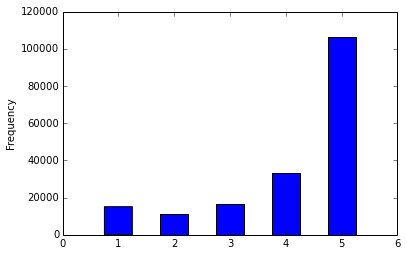

In [10]:
%matplotlib inline
reviews['rating'].plot(kind='hist', range=(1, 6), align = 'left')

People like sharing good experiences :)

#### Find the most bought product

In [11]:
reviews.groupby('name').count().sort_values(['review'], ascending=False).head(n=10)

,review,rating
name,,
Vulli Sophie the Giraffe Teether,779,779
"Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L",560,560
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision,558,558
Baby Einstein Take Along Tunes,545,545
"Cloud b Twilight Constellation Night Light, Turtle",517,517
"Fisher-Price Booster Seat, Blue/Green/Gray",487,487
Fisher-Price Rainforest Jumperoo,446,446
"Graco Nautilus 3-in-1 Car Seat, Matrix",418,418
Leachco Snoogle Total Body Pillow,388,388


#### Let's focus on a chewing toy

In [12]:
giraffe_reviews = reviews[reviews['name'] == 'Vulli Sophie the Giraffe Teether']

In [13]:
len(giraffe_reviews)

779

In [15]:
giraffe_reviews['rating'].value_counts(sort = False, normalize = True)

1    0.071887
2    0.047497
3    0.079589
4    0.119384
5    0.681643
Name: rating, dtype: float64

### Build a sentiment classifier

#### Define what's a positive and a negative sentiment
We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.  Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.   

In [19]:
#ignore all 3* reviews
products = reviews[reviews['rating'] != 3]

#positive sentiment = 4* or 5* reviews
products.loc[:, 'sentiment'] = 0
products.loc[products.rating >= 4, 'sentiment'] = 1

products.iloc[15:25]

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,name,review,rating,sentiment
17,Nature\'s Lullabies Second Year Sticker Calendar,This was the only calender I could find for th...,5,1
18,Nature\'s Lullabies Second Year Sticker Calendar,I completed a calendar for my son\'s first yea...,4,1
19,Nature\'s Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
20,Nature\'s Lullabies Second Year Sticker Calendar,I had a hard time finding a second year calend...,5,1
21,Nature\'s Lullabies Second Year Sticker Calendar,I only purchased a second-year calendar for my...,2,0
22,Nature\'s Lullabies Second Year Sticker Calendar,I LOVE this calendar for recording events of m...,5,1
24,Nature\'s Lullabies Second Year Sticker Calendar,Wife loves this calender. Comes with a lot of ...,5,1
25,Nature\'s Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
26,Baby\'s First Journal - Green,"Extremely useful! As a new mom, tired and inex...",5,1
28,"Lamaze Peekaboo, I Love You","One of baby\'s first and favorite books, and i...",4,1


In [20]:
pd.set_option('precision', 2)
products.describe()

,rating,sentiment
count,165679.00,165679.00
mean,4.23,0.84
std,1.30,0.37
min,1.00,0.00
25%,4.00,1.00
50%,5.00,1.00
75%,5.00,1.00
max,5.00,1.00


#### Calculate the word count vector for each review

##### First let's do it for all words present in any review then for just some selected ones

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer()

In [22]:
# The resulting array is big and sparse
count_features=countvec.fit_transform(products.review)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [23]:
# We can show the word counts for a small subset of words
interesting_words = ['like', 'amazing', 'love', 'horrible', 'bad', 'meh', 'awful']
cv_some_words = CountVectorizer(vocabulary = interesting_words) 
some_words = pd.DataFrame(cv_some_words.fit_transform(products.review).toarray(), 
                          columns=cv_some_words.get_feature_names())

In [24]:
some_words.head()

,like,amazing,love,horrible,bad,meh,awful
0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0
2,1,0,2,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0


#### Fit a Logistic Regression model

In [25]:
from sklearn.cross_validation import train_test_split

In [26]:
X = count_features
y = products.sentiment

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
# our model - a multiclass regression
logistic = LogisticRegression()

# train on iris training set
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
pred = logistic.predict(X_test)

In [30]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
# Area under the ROC curve
metrics.auc(fpr, tpr)

0.85278639391898869

In [31]:
# How are the categories misclassified
metrics.confusion_matrix(y_test, pred, labels = [0, 1])

array([[ 5890,  2135],
       [ 1183, 40496]])

In [32]:
# How much of the predictions are correct
# In the lecture we got 'accuracy': 0.916256305548883
metrics.accuracy_score(y_test, pred, normalize=True)

0.9332448092708836

#### Let's go back to the chewing toy

In [33]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']
giraffe_reviews.head()

,name,review,rating,sentiment
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,1
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,1
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,0
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5,1
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,1


In [61]:
giraffe_features = countvec.fit_transform(giraffe_reviews.review)

In [62]:
giraffe_reviews['predicted_sentiment'] = logistic.predict_proba(giraffe_features)

ValueError: X has 3242 features per sample; expecting 64130